In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize((0.5,), (0.5,)),

])

In [4]:
traindata  = datasets.MNIST(root = './datasetfolder', download = True, train = True, transform = trans)
testdata = datasets.MNIST(root = './datasetfolder', download = True, train = False, transform = trans)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasetfolder/MNIST/raw/train-images-idx3-ubyte.gz to ./datasetfolder/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasetfolder/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasetfolder/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasetfolder/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasetfolder/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasetfolder/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasetfolder/MNIST/raw



In [5]:
print(len(traindata))
print(len(testdata))

60000
10000


In [6]:
trainloader = DataLoader(dataset = traindata, batch_size = 128, shuffle = True)
testloader = DataLoader(dataset = testdata, batch_size = 128)

In [7]:
print(len(trainloader))
a, b = next(iter(trainloader))
print(a.shape)
print(b.shape)

469
torch.Size([128, 1, 224, 224])
torch.Size([128])


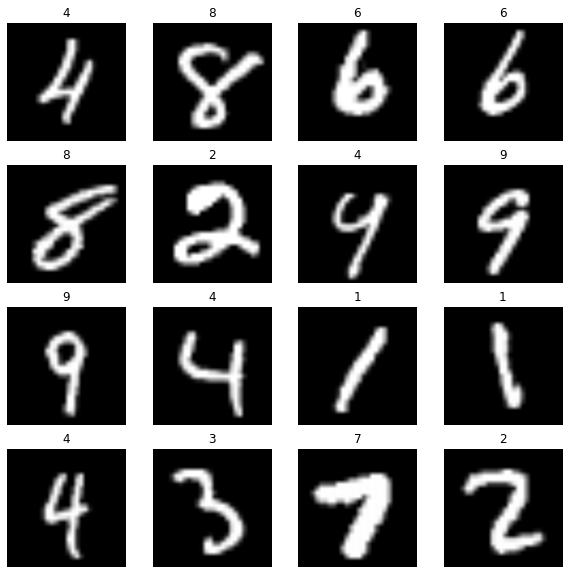

In [8]:
plt.figure(figsize = (10, 10))
for i in range(1, 16+1):
  plt.subplot(4, 4, i)
  plt.imshow(a[i].squeeze(), cmap = 'gray')
  plt.title(b[i].item())
  plt.axis('off')

In [9]:
def conv_1(in_dim, out_dim): # 1x1 conv
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, 1, 1),
      nn.ReLU()
  )
  return model


def conv_1_3(in_dim, mid_dim, out_dim): #1x1 conv -> 3x3 conv
  model = nn.Sequential(
      nn.Conv2d(in_dim, mid_dim, 1, 1),
      nn.ReLU(),
      nn.Conv2d(mid_dim, out_dim, 3, 1, 1),
      nn.ReLU()
  )
  return model

def conv_1_5(in_dim, mid_dim, out_dim): #1x1 conv -> 5x5 conv
  model = nn.Sequential(
      nn.Conv2d(in_dim, mid_dim, 1, 1),
      nn.ReLU(),
      nn.Conv2d(mid_dim, out_dim, 5, 1, 2),
      nn.ReLU()
  )
  return model


def max_3_1(in_dim, out_dim):
  model = nn.Sequential(
      nn.MaxPool2d(3, 1, 1),
      nn.Conv2d(in_dim, out_dim, 1, 1),
      nn.ReLU()
  )
  return model

In [10]:
class Inception_module(nn.Module):
  def __init__(self, in_dim, out_dim_1, mid_dim_3, out_dim_3, mid_dim_5, out_dim_5, pool_dim):
    super().__init__()

    self.conv_1 = conv_1(in_dim,out_dim_1)
    self.conv_1_3 = conv_1_3(in_dim, mid_dim_3, out_dim_3)
    self.conv_1_5 = conv_1_5(in_dim, mid_dim_5, out_dim_5)
    self.max_3_1 = max_3_1(in_dim, pool_dim)
  
  def forward(self, x):
    out1 = self.conv_1(x)
    out2 = self.conv_1_3(x)
    out3 = self.conv_1_5(x)
    out4 = self.max_3_1(x)

    output = torch.cat([out1, out2, out3, out4], 1)
    return output

In [11]:
class Aux_classifier(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Sequential(
        nn.AvgPool2d(5, 3),
        nn.Conv2d(in_channels, 128, kernel_size = 1)
    )
    self.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1024, num_classes)
    )
  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [12]:
class GoogleNet(nn.Module):
  def __init__(self, base_dim = 64, Train_mode = True, num_classes = 10):
    super().__init__()
      
    self.init_layer = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = base_dim, kernel_size = 7, stride = 2, padding = 3),
        nn.MaxPool2d(3, 2, 1),
        nn.Conv2d(in_channels = base_dim, out_channels = base_dim * 3, kernel_size = 3, stride = 1, padding = 1),
        nn.MaxPool2d(3, 2, 1)
    )


    self.inception3a = Inception_module(base_dim * 3, 64, 96, 128, 16, 32, 32)
    self.LR =  nn.LocalResponseNorm(2)
    self.inception3b = Inception_module(base_dim * 4, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(3, 2, 1)
    

    self.inception4a = Inception_module(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_module(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_module(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_module(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_module(528, 256, 160, 320, 32, 128, 128)

    self.maxpool4 = nn.MaxPool2d(3, 2, 1)

    self.inception5a = Inception_module(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_module(832, 384, 192, 384, 48, 128, 128)
    self.avgpool = nn.AvgPool2d(7, 1)
    
    self.dropout = nn.Dropout2d(0.4)
    self.fc_1 = nn.Linear(1024, num_classes)

    if Train_mode:
      self.aux1 = Aux_classifier(512, num_classes)
      self.aux2  = Aux_classifier(528, num_classes)
    else:
      self.aux1 = None
      self.aux2 = None


  def forward(self, x):
    x = self.init_layer(x)
    x = self.inception3a(x)
    x = self.LR(x)
    x = self.inception3b(x)
    x = self.LR(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)
    x = self.LR(x)

    if self.aux1 is not None:
      aux1 = self.aux1(x)
    
    x = self.inception4b(x)
    x = self.LR(x)
    x = self.inception4c(x)
    x = self.LR(x)
    x = self.inception4d(x)

    if self.aux2 is not None:
      aux2 = self.aux2(x)
    
    x = self.inception4e(x)
    x = self.LR(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.LR(x)
    x = self.inception5b(x)
    x = self.LR(x)
    x = self.avgpool(x)

    x = x.view(x.shape[0], -1)

    x = self.dropout(x)
    x = self.fc_1(x)

    if self.aux1 is not None:
      return [x, aux1, aux2]
    else:
      return x



In [13]:
def weight_initialization(m):
  if type(m) == nn.Conv2d:
    nn.init.normal_(m.weight, 0, 0.01)
    print('init success')
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, 0, 0.01)
    print('init success')

In [14]:
model =GoogleNet(Train_mode = True).to(device)
input = torch.rand(3, 1, 224, 224).to(device)
model.apply(weight_initialization)

init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success


GoogleNet(
  (init_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (inception3a): Inception_module(
    (conv_1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (conv_1_3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_1_5): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
    (max_3_1): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, 

In [15]:
output, aux1, aux2 = model(input)
print(output.shape)
print(aux1.shape)
print(aux2.shape)

torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([3, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [23]:
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr = 1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

In [24]:
def accuracy_rate(pred, target):
  pred = pred.argmax(dim = 1)
  correct = pred.eq(target.view_as(pred)).sum().item()

  return correct

In [25]:
def model_train(model, trainloader, optim, loss_func, device, train = True):
  model.train()

  running_loss = 0.0
  running_acc = 0.0
  for imgs, labels in trainloader:
    
    optim.zero_grad()
    imgs, labels = imgs.to(device), labels.to(device)
    output, aux1, aux2 = model(imgs)
    total_loss = 0.3 * loss_func(aux1, labels) + 0.3 * loss_func(aux1, labels) + loss_func(output, labels)

    running_loss += total_loss.item()
    running_acc += accuracy_rate(output, labels)

    total_loss.backward()
    optim.step()

  return running_loss, running_acc * 100

In [26]:
def model_val(model, testloader, loss_func, device, train = False):
  model.eval()
  
  running_loss = 0.0
  running_acc = 0.0

  with torch.no_grad():
    
    for imgs, labels in testloader:
      imgs, labels = imgs.to(device), labels.to(device)

      output = model(imgs)[0]

      total_loss = loss_func(output, labels)

      running_loss += total_loss.item()
      running_acc += accuracy_rate(output, labels)
    
    return running_loss, running_acc * 100

In [ ]:
epochs = 100
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(epochs):

  train_loss, train_acc = model_train(model, trainloader, optimizer, loss_func, device, train = True)

  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  print('Epoch : ', epoch +1, 'Loss : {:.3f}'.format(train_loss), 'Acc : {:.2f}'.format(train_acc))

  val_loss, val_acc = model_val(model, testloader, loss_func, device)

  print('Loss : {:.3f}'.format(val_loss), 'Acc : {:.2f}'.format(val_acc))